# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pycountry_convert as pc
import statsmodels.formula.api as sm
from statsmodels.tsa.seasonal import STL
from scipy.stats import pearsonr
from scipy.misc import derivative
from scipy.optimize import fsolve
import numpy as np

C:\Users\mikol\anaconda3\envs\weather\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
sns.set_style('darkgrid')

# Data view

In [3]:
df = pd.read_csv('final_data.csv')

In [4]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year
0,1900-01-01,-3.026,0.538,Åland,1900
1,1900-02-01,-8.063,0.657,Åland,1900
2,1900-03-01,-3.196,0.467,Åland,1900
3,1900-04-01,0.781,0.224,Åland,1900
4,1900-05-01,4.960,0.503,Åland,1900


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326926 entries, 0 to 326925
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             326926 non-null  object 
 1   AverageTemperature             326926 non-null  float64
 2   AverageTemperatureUncertainty  326926 non-null  float64
 3   Country                        326926 non-null  object 
 4   year                           326926 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 12.5+ MB


In [6]:
df.dt = pd.to_datetime(df.dt)

In [7]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty,year
count,326926.000000,326926.000000,326926.000000
mean,18.826082,0.446003,1956.126683
std,10.492642,0.302792,32.602336
min,-37.177000,0.052000,1900.000000
25%,13.175000,0.259000,1928.000000
50%,23.210000,0.364000,1956.000000
75%,26.348000,0.537000,1984.000000
max,38.842000,8.425000,2012.000000


In [8]:
df.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
year                             0
dtype: int64

# Aggregate to continents

In [9]:
def get_continent(country):
    
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except:
        pass
    
df['Continent'] = df.apply(lambda row: get_continent(row.Country), axis=1)

In [10]:
df[df.Continent.isna()].loc[:, 'Country'].unique() # to be mapped/removed

array(['Åland', 'Africa', 'Antigua And Barbuda', 'Asia', 'Baker Island',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina',
       'Burma', "Côte D'Ivoire", 'Congo (Democratic Republic Of The)',
       'Denmark (Europe)', 'Europe', 'Falkland Islands (Islas Malvinas)',
       'Federated States Of Micronesia', 'France (Europe)',
       'French Southern And Antarctic Lands', 'Gaza Strip',
       'Guinea Bissau', 'Heard Island And Mcdonald Islands',
       'Isle Of Man', 'Kingman Reef', 'Netherlands (Europe)',
       'North America', 'Oceania', 'Palestina', 'Palmyra Atoll',
       'Reunion', 'Saint Kitts And Nevis', 'Saint Pierre And Miquelon',
       'Saint Vincent And The Grenadines', 'Sao Tome And Principe',
       'Sint Maarten', 'South America',
       'South Georgia And The South Sandwich Isla',
       'Svalbard And Jan Mayen', 'Timor Leste', 'Trinidad And Tobago',
       'Turks And Caicas Islands', 'United Kingdom (Europe)',
       'Virgin Islands', 'Western Sahar

In [11]:
#TODO instead of this there should be mapping of not detected countries to continent 
df.dropna(inplace=True)

In [12]:
def avg_continent(continent):    
    time_series = pd.DataFrame(df[df.Continent==continent].groupby('dt').AverageTemperature.mean())
    time_series['Continent'] = continent
    time_series['x'] = list(range(len(time_series)))
    return time_series

agg_continents = pd.concat([avg_continent(continent) for continent in df.Continent.unique()])

# Growth significancy

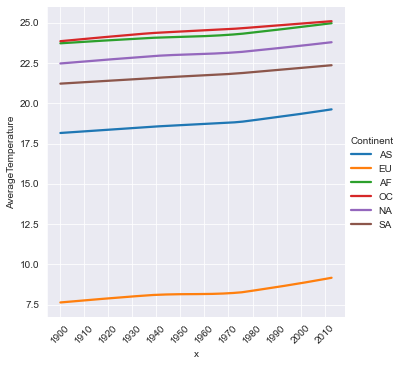

In [13]:
g = sns.lmplot(data=agg_continents, x='x', y='AverageTemperature', hue='Continent', scatter=False, lowess=True)
g.axes.flat[0].set_xticks(list(range(0, len(agg_continents.index.unique()), 120)))
g.axes.flat[0].set_xticklabels(list(df.year.unique())[::10], rotation=45)
g

In [14]:
def linear_regression(continental):

    data = pd.DataFrame({'x': list(range(len(continental))), 'y': continental.values})
    return sm.ols(data=data, formula='y ~ x').fit().params.x

    
agg_continents.groupby('Continent').AverageTemperature.agg(linear_regression).reset_index()

,Continent,AverageTemperature
0,AF,0.000782
1,AS,0.000962
2,EU,0.000897
3,NA,0.000862
4,OC,0.000839
5,SA,0.000792


In [15]:
# consider using another test

def correlation_test(continental):

    # optional but gives different results - to consider
    res = STL(continental.values, period=12, seasonal=3).fit() # value of `seasonal` can be changed
    continental -= res.seasonal
    data = pd.DataFrame({'x': list(range(len(continental))), 'y': continental.values})
    return pearsonr(data.x, data.y)

    
agg_continents.groupby('Continent').AverageTemperature.agg(correlation_test).reset_index()

,Continent,AverageTemperature
0,AF,"(0.8247250928936697, 0.0)"
1,AS,"(0.8159298770185917, 0.0)"
2,EU,"(0.6282213563675594, 8.912846633255064e-150)"
3,NA,"(0.8385378337098922, 0.0)"
4,OC,"(0.9243963774691318, 0.0)"
5,SA,"(0.8324591948859499, 0.0)"


# Start of global warming

In [16]:
def inflection_point(y, deg=3):
    
    x = np.arange(len(y))
    x0 = np.mean([x[0], x[-1]])
    coef = np.polyfit(x, y, deg)
    construct_polynomial = lambda coef: np.vectorize(
        lambda x: np.dot(coef, np.array([x**i for i in range(len(coef)-1, -1, -1)])))
    return y.index[int(round(fsolve(lambda x_prime: derivative(construct_polynomial(coef), x_prime, n=2), x0)[0]))], coef[0]

agg_continents.groupby('Continent').AverageTemperature.agg(inflection_point).reset_index()

,Continent,AverageTemperature
0,AF,"(1949-04-01 00:00:00, 1.8053325466528924e-09)"
1,AS,"(1946-07-01 00:00:00, 1.8284294118916933e-09)"
2,EU,"(1949-08-01 00:00:00, 3.4136164324250806e-09)"
3,NA,"(1951-11-01 00:00:00, 1.605573904742761e-09)"
4,OC,"(1960-01-01 00:00:00, 1.0367298030366918e-09)"
5,SA,"(1914-01-01 00:00:00, 1.7742792737625908e-10)"
